# DDPG W/ AI GYM PENDULUM

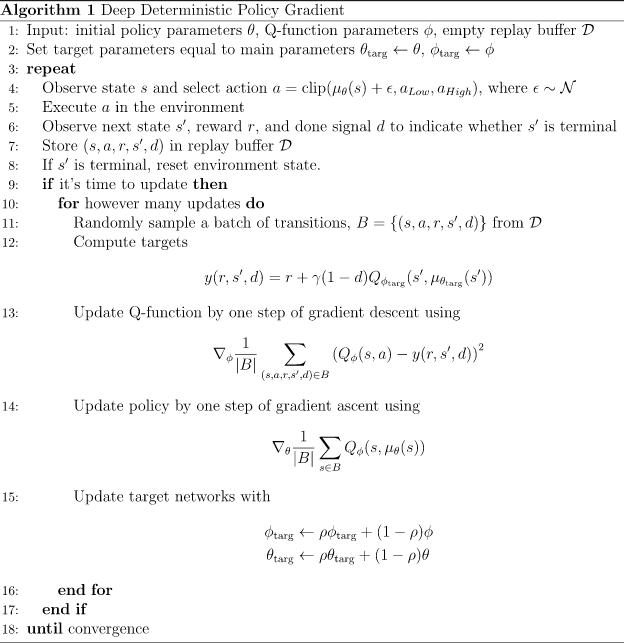


https://spinningup.openai.com/en/latest/algorithms/ddpg.html


In [1]:
import numpy as np
import gymnasium as gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.2, min_sigma=0, decay_period=50000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)       

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size  + output_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors        
        """
        
        x = F.relu(self.linear1(state)) 
        x = torch.cat([x, action], 1)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn


class DDPGagent:
    def __init__(self, 
                 env, 
                 hidden_size=256, 
                 actor_learning_rate=1e-4, 
                 critic_learning_rate=1e-3, 
                 gamma=0.99, tau=1e-2, 
                 max_memory_size=50000,
                 device = None):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        
        if device is not None:
            self.device = device
        else:
            self.device = 'cpu'

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions).to(self.device)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions).to(self.device)
        self.critic = Critic(self.num_states, hidden_size, self.num_actions).to(self.device)
        self.critic_target = Critic(self.num_states, hidden_size, self.num_actions).to(self.device)
        
        #copy params
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.FloatTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
    
        # Critic loss  
        # get Qvals
        Qvals = self.critic.forward(states, actions)
        #get next actions from actor
        next_actions = self.actor_target.forward(next_states)
        #get next action values from critic target
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        #calculate q prime (used in critic loss)
        Qprime = rewards + self.gamma * next_Q
        #calc loss btw Qvals and Qprime
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        #update critic
        self.critic_optimizer.zero_grad(set_to_none = True)        
        critic_loss.backward() 
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 25)  
        self.critic_optimizer.step()        

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update actor
        self.actor_optimizer.zero_grad(set_to_none = True)
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 25)
        self.actor_optimizer.step()

        # soft update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            

episode: 0, reward: -3170.14, average _reward: -3170.1394677387293
episode: 1, reward: -4284.76, average _reward: -3727.45170062544
episode: 2, reward: -2639.91, average _reward: -3364.9362402730276
episode: 3, reward: -3159.18, average _reward: -3313.4973926703155
episode: 4, reward: -1920.96, average _reward: -3034.990602409499
episode: 5, reward: -1897.82, average _reward: -2845.4617459222586
episode: 6, reward: -997.97, average _reward: -2581.5347017264603
episode: 7, reward: -378.42, average _reward: -2306.145844311805
episode: 8, reward: -734.59, average _reward: -2131.5287738064426
episode: 9, reward: -735.34, average _reward: -1991.9096676675108
episode: 10, reward: -481.49, average _reward: -1723.044710642096
episode: 11, reward: -994.71, average _reward: -1394.0397865532868
episode: 12, reward: -380.07, average _reward: -1168.0561974585312
episode: 13, reward: -252.6, average _reward: -877.3977263050386
episode: 14, reward: -1.03, average _reward: -685.4039551157318
episode: 

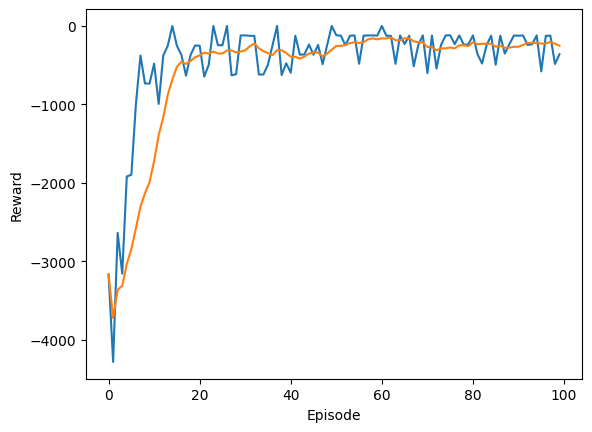

In [4]:
import sys
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = gym.make("Pendulum-v1")

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []
total_steps = 0

for episode in range(100):
    state = env.reset()[0]
    noise.reset()
    episode_reward = 0
    
    for step in range(500):
        

        action = agent.get_action(state)
        action = noise.get_action(action, total_steps)
        new_state, reward, done, trunc, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward
        
        total_steps += 1

        if done or step>=499:
            rewards.append(episode_reward)
            avg_rewards.append(np.mean(rewards[-10:]))
            print("episode: {}, reward: {}, average _reward: {}".format(episode, 
                                                                        np.round(episode_reward, decimals=2),
                                                                        np.mean(rewards[-10:])))            
            break    

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
